<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/ClaimYNprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df.head()

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609.0,Urban,6213.71,25,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1,5100.171753
1,182,44,Female,3,Married,Commute,575.0,Urban,12427.42,20,...,58.0,24.0,11.0,1099.0,615.0,219.0,101.0,40.0,1,883.554840
2,184,48,Female,6,Married,Commute,847.0,Urban,12427.42,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
3,183,71,Male,6,Married,Private,842.0,Urban,6213.71,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,183,84,Male,10,Married,Private,856.0,Urban,6213.71,65,...,2.0,0.0,0.0,325.0,111.0,18.0,4.0,2.0,0,0.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.drive.tue        

# Step 2: Data Preprocessing


In [15]:
# Derive the target variable
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

# Drop unnecessary columns
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

# Handle missing values (if any)
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target variable
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [16]:
df.head()

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Territory,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,...,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,ClaimYN,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,70,0.849315,8864.376247,0.148070,...,0.0,0.0,0.0,1,True,False,True,False,False,True
1,182,44,3,575.0,12427.42,20,26,0.465753,8092.308208,0.147686,...,219.0,101.0,40.0,0,False,False,True,False,False,True
2,184,48,6,847.0,12427.42,14,84,0.520548,3225.832512,0.153735,...,0.0,0.0,0.0,0,False,False,True,False,False,True
3,183,71,6,842.0,6213.71,43,30,0.065753,253.024528,0.106702,...,0.0,0.0,0.0,0,True,False,False,False,True,True
4,183,84,10,856.0,6213.71,65,70,0.441096,4374.379634,0.123807,...,18.0,4.0,2.0,0,True,False,False,False,True,True


In [18]:
# Access the 'ClaimYN' column from the DataFrame 'df'
df['ClaimYN'].describe()  # Use .describe() for distribution statistics

# Or, if you want the ClaimYN Series:
ClaimYN_series = df['ClaimYN']
ClaimYN_series.describe()

,ClaimYN
count,100000.000000
mean,0.026980
std,0.162026
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Step 3: Handle Class Imbalance


In [19]:
# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Display class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())


Class distribution after SMOTE:
ClaimYN
1    97302
0    97302
Name: count, dtype: int64


Step 4: Feature Selection

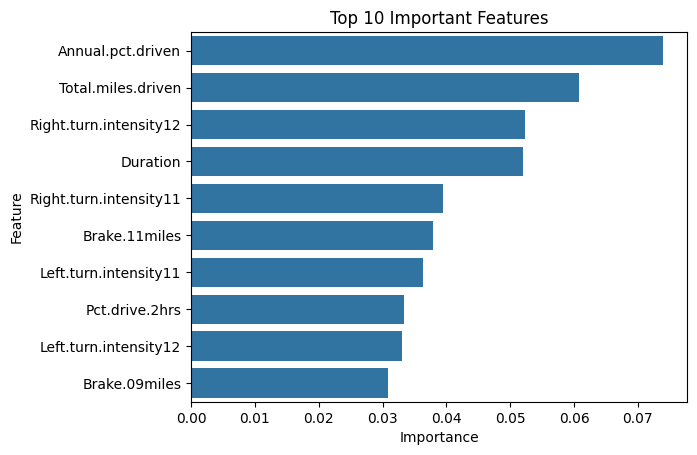

In [20]:
# Using a Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

# Get feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 important features
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features')
plt.show()

# Optionally select the top features
selected_features = feature_importances.head(20)['Feature'].values
X_resampled = X_resampled[:, [X.columns.get_loc(f) for f in selected_features]]
